<h1>Regression</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h2>Laden der Daten</h2>

In [2]:
df_de = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_DE_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

df_de["Date"] = pd.to_datetime(df_de.created_at).apply(lambda x: x.date())
df_de["sentiment_bert"] = df_de["sentiment_bert"].replace(["neutral", "negative", "positive"], ["NEU", "NEG", "POS"])
#df["sentiment_vader"] = df["sentiment_vader"].replace(["0", "-1", "1"], ["NEU", "NEG", "POS"])

In [3]:
df_en = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

df_en["Date"] = pd.to_datetime(df_en.created_at).apply(lambda x: x.date())

In [4]:
df = pd.concat([df_en, df_de]).reset_index(drop=True)

In [5]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])
df_wdi = df_wdi.rename(columns={"Adj Close": "Adj_Close"})

<h2>Vorverarbeitung der Daten</h2>

In [6]:
#Berechnung der Returns für Log
df_wdi["returns"] = np.log(df_wdi.Close.pct_change() + 1)
df_wdi["returns_2"] = df_wdi.Close.pct_change() + 1
#df_wdi["returns_5"] = df_wdi.Close.pct_change(periods=5) + 1

#Change Date für df_wdi & df
df_wdi["Date"] = pd.to_datetime(df_wdi.Date).apply(lambda x: x.date())


In [7]:
#Berechnung der Lags
def lagit(df, lags, shifter, drop=False):
    names = []
    for each in shifter:
        for i in range(1, lags+1):
            df["Lag_"+each+"_"+str(i)] = df[each].shift(i)
            names.append("Lag_"+each+"_"+str(i))
    if drop:
        df.dropna(inplace=True)
        df = df.reset_index(drop=True)
    return names, df

In [8]:
#Create a Support DF to calculate all different values, that might be useful.
def sup_df_for_calculations(df_test, sentiment = "sentiment_bert"):
    
    
    #Create the support df with the conversation id and the date from the df
    df_sup = df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index().rename(columns={"conversation_id": "count_tweets_all"})

    #Add Number of POS Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_pos"}).fillna(0)

    #Add Number of NEG Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_neg"}).fillna(0)

    #Add sum of retweet count to DF
    df_sup = df_sup.merge(df_test[["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_all"}).fillna(0)

    #Add sum of POS retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_pos"}).fillna(0)

    #Add sum of NEG retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_neg"}).fillna(0)

    #Add sum of liked tweets to DF
    df_sup = df_sup.merge(df_test[["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_all"}).fillna(0)

    #Add sum of POS liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_pos"}).fillna(0)

    #Add sum of NEG liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_neg"}).fillna(0)

    #Add POS in relation to POS+NEG in percentage
    df_sup["pct_pos"] = df_sup.count_tweets_pos / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add NEG in relation to POS+NEG in percentage
    df_sup["pct_neg"] = df_sup.count_tweets_neg / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add POS in relation to all tweets in percentage
    df_sup["pct_pos_all"] = df_sup.count_tweets_pos / df_sup.count_tweets_all

    #Add NEG in relation to all tweets in percentage
    df_sup["pct_neg_all"] = df_sup.count_tweets_neg / df_sup.count_tweets_all

    #Add sum of POS tweets, liked and retweets
    df_sup["sum_pos_like_retweet"] = df_sup.count_tweets_pos + df_sup.sum_like_pos + df_sup.sum_retweet_pos

    #Add sum of NEG tweets, liked and retweets
    df_sup["sum_neg_like_retweet"] = df_sup.count_tweets_neg + df_sup.sum_like_neg + df_sup.sum_retweet_neg

    #Add sum of all tweets, liked and retweets
    df_sup["sum_all_like_retweet"] = df_sup.count_tweets_all + df_sup.sum_like_all + df_sup.sum_retweet_all

    #Add pct of POS_sum to NEG_sum and POS_sum
    df_sup["pct_pos_sum"] = df_sup.sum_pos_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of NEG_sum to NEG_sum and POS_sum
    df_sup["pct_neg_sum"] = df_sup.sum_neg_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of POS_sum to ALL_sum
    df_sup["pct_pos_sum_all"] = df_sup.sum_pos_like_retweet / df_sup.sum_all_like_retweet

    #Add pct of NEG_sum to ALL_sum
    df_sup["pct_neg_sum_all"] = df_sup.sum_neg_like_retweet / df_sup.sum_all_like_retweet

    #Add prod between POS tweets and liked, retweets
    df_sup["prod_pos_like_retweet"] = df_sup.count_tweets_pos * [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]

    #Add prod between NEG tweets and liked, retweets
    df_sup["prod_neg_like_retweet"] = df_sup.count_tweets_neg * [1 if i == 0 else i for i in (df_sup.sum_like_neg + df_sup.sum_retweet_neg)]

    #Add prod between all tweets and liked, retweets
    df_sup["prod_all_like_retweet"] = df_sup.count_tweets_all * [1 if i == 0 else i for i in (df_sup.sum_like_all + df_sup.sum_retweet_all)]

    #Add pct of POS_prod to NEG_prod and POS_prod
    df_sup["pct_pos_prod"] = df_sup.prod_pos_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of NEG_prod to NEG_prod and POS_prod
    df_sup["pct_neg_prod"] = df_sup.prod_neg_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of POS_prod to all_prod
    df_sup["pct_pos_prod_all"] = df_sup.prod_pos_like_retweet / df_sup.prod_all_like_retweet

    #Add pct of NEG_prod to all_prod
    df_sup["pct_neg_prod_all"] = df_sup.prod_neg_like_retweet / df_sup.prod_all_like_retweet
    
    #Add relation of POS and NEG
    df_sup["relation_pos_neg"] = (df_sup["count_tweets_pos"] / df_sup["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of NEG and POS
    df_sup["relation_neg_pos"] = (df_sup["count_tweets_neg"] / df_sup["count_tweets_pos"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum POS and NEG
    df_sup["relation_sum_pos_neg"] = (df_sup["sum_pos_like_retweet"] / df_sup["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum NEG and POS
    df_sup["relation_sum_neg_pos"] = (df_sup["sum_neg_like_retweet"] / df_sup["sum_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod POS and NEG
    df_sup["relation_prod_pos_neg"] = (df_sup["prod_pos_like_retweet"] / df_sup["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod NEG and POS
    df_sup["relation_prod_neg_pos"] = (df_sup["prod_neg_like_retweet"] / df_sup["prod_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Return the support df
    return df_sup



In [103]:
def add_further_regressors(df):
    df["sentiment_day"] = df["count_tweets_pos"] - df["count_tweets_neg"]
    df["sentiment_day_sum"] = df["sum_pos_like_retweet"] - df["sum_neg_like_retweet"]
    df["sentiment_day_prod"] = df["prod_pos_like_retweet"] - df["prod_neg_like_retweet"]
    
    df["sentiment_dummy"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day]
    df["sentiment_dummy_sum"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day_sum]
    df["sentiment_dummy_prod"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day_prod]
    
    df["sum_pos_tweets_retweets"] = df["count_tweets_pos"] + df["sum_retweet_pos"]
    df["sum_neg_tweets_retweets"] = df["count_tweets_neg"] + df["sum_retweet_pos"]
    
    df["pos_close"] = df["Adj_Close"] * df["pct_pos_sum"]
    df["pos_returns"] = df["returns"] * df["pct_pos_sum_all"]
    
    df["indicator"] =  [1 if i > 1 else -1 if i < 1 else 0 for i in df["returns_2"]]
    
    return df

In [10]:
def log_fkt(df, column):
    df[column] = np.log(df[column]).replace([np.inf, -np.inf], 0)
    
    return df

<h2>Lineare Regression mit Statsmodels</h2>

In [157]:
def regression(df, regressor, output):

    train, test = train_test_split(df, shuffle=False, test_size=0.05, random_state=0)
    
    train_x = train[regressor]
    train_y = train[output]
    
    test_x = test[regressor]
    test_y = test[output]
    
    #train_x, train_y = np.array(train_x), np.array(train_y)
    #test_x, test_y = np.array(test_x), np.array(test_y)
    
    train_x = sm.add_constant(train_x)
    test_x = sm.add_constant(test_x)
    
    model = sm.OLS(train_y, train_x).fit()
    
    predictions = model.predict(test_x)
    
    print_model = model.summary()
    
    #print(predictions)
    print(print_model)
    
    #Calculate the scuared mean squared error on the predicted values based on the real values. 
    print("Mean Squared Error: ", np.sqrt(mean_squared_error(test_y, predictions)))
    
    #Calulate the r2 values based on the prediccted and the real values, 
    print("R2: ", r2_score(test_y, predictions))
    
    return model, predictions, test, test_y

In [12]:
def regression_all(df, regressor, output):
    
    #regressor = np.array(df[regressor])

    #regressor = sm.add_constant(regressor)
    
    x = df[regressor]
    y = df[output]
    
    x = sm.add_constant(x)

    #model = sm.OLS(df[output], regressor).fit()
    model = sm.OLS(y,x).fit()
    
    #predictions = model.predict(regressor)
    predictions = model.predict(x)
    
    pritn_model = model.summary()
    
    print(pritn_model)
    
    return predictions, model

In [13]:
def test_regression(df, regressor, output, lag_num, train_test = True, log = False, log_2 = False):
    
    print("=========================", regressor, "=========================\n")
    
    df_wdi_sentiment = create_df(df)
    regressor = [regressor]
    
    if log:
        df_wdi_sentiment = log_fkt(df_wdi_sentiment, regressor)
    
    if log_2:
        df_wdi_sentiment = log_fkt(df_wdi_sentiment, output)
    
    df_wdi_sentiment = add_further_regressors(df_wdi_sentiment)
    
    lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
    
    for each in range(len(lagnames)):
        print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))
    if train_test:
        reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)
    else:
        reg_predictions, reg_model = regression_all(df_wdi_sentiment, lagnames, output)
        
    return df_wdi_sentiment, lagnames, reg_predictions

In [14]:
def create_df(df, df_wdi = df_wdi):
    df_sentiment = sup_df_for_calculations(df)
    df_wdi_sentiment = df_wdi.merge(df_sentiment.rename(columns={"created_at": "Date"}), how="left", on="Date").fillna(0)
    return df_wdi_sentiment

<h2>Plot</h2>

In [15]:
def plot_regression(df, regressor, regressant, prediction):
    plt.figure(figsize=(50,10))
    
    plt.scatter(df[regressor], df[regressant], color="blue")
    plt.plot(df[regressor], prediction, color="red")
    
    plt.show()

<h2>Ausführung</h2>

<h3>Testen von mehreren Regressionen nacheinander</h3>

In [ ]:
#For testing a lot of regressions at a time
regressor = ['Adj Close', 'Volume',
       'returns', 'returns_2', 'count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all', 'relation_pos_neg',
       'relation_neg_pos', 'relation_sum_pos_neg', 'relation_sum_neg_pos',
       'relation_prod_pos_neg', 'relation_prod_neg_pos',
            "sentiment_day", "sentiment_day_sum", "sentiment_day_prod", "sentiment_dummy", "sentiment_dummy_sum", "sentiment_dummy_prod"]
#pos_close
#pos_returns
regressor = ["Adj Close"]
output = "Adj Close"
lag_num = 1
train_test = False
log_regressor = False
log_output = False

for each in regressor:
    df_wdi_sentiment,  reg_regressor, reg_predictions = test_regression(df, each, output, lag_num, train_test, 
                                                                        log_regressor, log_output)
    #plot_regression(df_wdi_sentiment, reg_regressor[0], output, reg_predictions)
    print("==================================================\n\n\n")

In [ ]:
plt.figure(figsize=(100,50))

plt.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["returns"], color="blue")
plt.plot(df_wdi_sentiment["Date"],  reg_predictions, color="red")


plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(50,25))
ax2 = ax1.twinx()
    
ax1.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["returns_2"], color="blue")
ax2.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["pct_pos_all"], color="green")
ax2.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["pct_neg_all"], color="red")

plt.show()

<h3>Regression mit mehreren Regressoren</h3>

In [310]:
#Do a more complex regression
#df_wdi_sentiment["sum_retweet_pos"]
#regressor = ["count_tweets_neg", "count_tweets_pos"]
#regressor = ["pct_pos_sum_all"]


regressor = ["pct_pos", 
            "pct_neg_all", "pct_pos_sum", 
            "pct_pos_sum", "pct_neg_sum_all", "pct_pos_prod"]

#regressor = ["returns_2"]
#regressor = ["count_tweets_pos", "count_tweets_neg"]
#regressor = ["sum_pos_like_retweet", "sum_neg_like_retweet"]
#regressor = ["pct_pos_all", "pct_neg_all"]
#regressor = ["pct_pos_sum", "pct_neg_sum"]
#regressor = ["pct_pos_sum"]
#regressor = ["pct_pos_sum_all", "pct_neg_sum_all"]
#regressor = ["pct_pos_sum_all"]
regressor = ["count_tweets_pos", "count_tweets_neg", "sum_pos_like_retweet", "sum_neg_like_retweet",
             "pct_pos_all", "pct_neg_all", "pct_pos_sum_all", "pct_neg_sum_all", "pos_close"]
regressor = ["pos_close"]

#regressor = ["return_close"]
#regressor = ["Adj_Close"]
#df_wdi_sentiment["sum_all_like_retweet"]

further_regressors = ["Volume", "count_tweets_all"]


output = "Adj_Close"

lagnames = []

lag_num = 5
train_test = True

df_wdi_sentiment = create_df(df)
df_wdi_sentiment = add_further_regressors(df_wdi_sentiment)


#####    Further fields    #####
df_wdi_sentiment["return_close"] = df_wdi_sentiment["returns_2"] * df_wdi_sentiment["pct_pos_sum_all"]

df_wdi_sentiment["Adj_Close_prev_day"] = df_wdi_sentiment["Adj_Close"].shift(1)
df_wdi_sentiment.dropna(subset=["Adj_Close_prev_day"], inplace=True)
df_wdi_sentiment["hybrid_feature"] = df_wdi_sentiment["Adj_Close"] + np.sign(df_wdi_sentiment["pct_pos_sum"]) * (df_wdi_sentiment["Adj_Close"] - df_wdi_sentiment["Adj_Close_prev_day"])


#####    Add Log    #####
df_wdi_sentiment[output] = np.log(df_wdi_sentiment[output])
if True:
    for each in regressor:
        df_wdi_sentiment[each] = np.log(df_wdi_sentiment[each]).replace([np.inf, -np.inf], 0)
    for each in further_regressors:
        df_wdi_sentiment[each] = np.log(df_wdi_sentiment[each]).replace([np.inf, -np.inf], 0)


#####    Add Lags to the dataset    ######
lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor)
#lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
lagnames.extend(lags)

lags, df_wdi_sentiment = lagit(df_wdi_sentiment, 1, further_regressors, True)
lagnames.extend(lags)


#####    Execute Regression    #####

reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)
#reg_predictions = regression_all(df_wdi_sentiment, lagnames, output)

                            OLS Regression Results                            
Dep. Variable:              Adj_Close   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     403.7
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          5.02e-295
Time:                        22:49:56   Log-Likelihood:                -146.80
No. Observations:                1078   AIC:                             309.6
Df Residuals:                    1070   BIC:                             349.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

/Users/tobias/Dev/FOM/Master_Thesis/master_thesis_3.9.10/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [311]:
r2_score(np.exp(reg_test_y), np.exp(reg_predictions))

0.8024714915269759

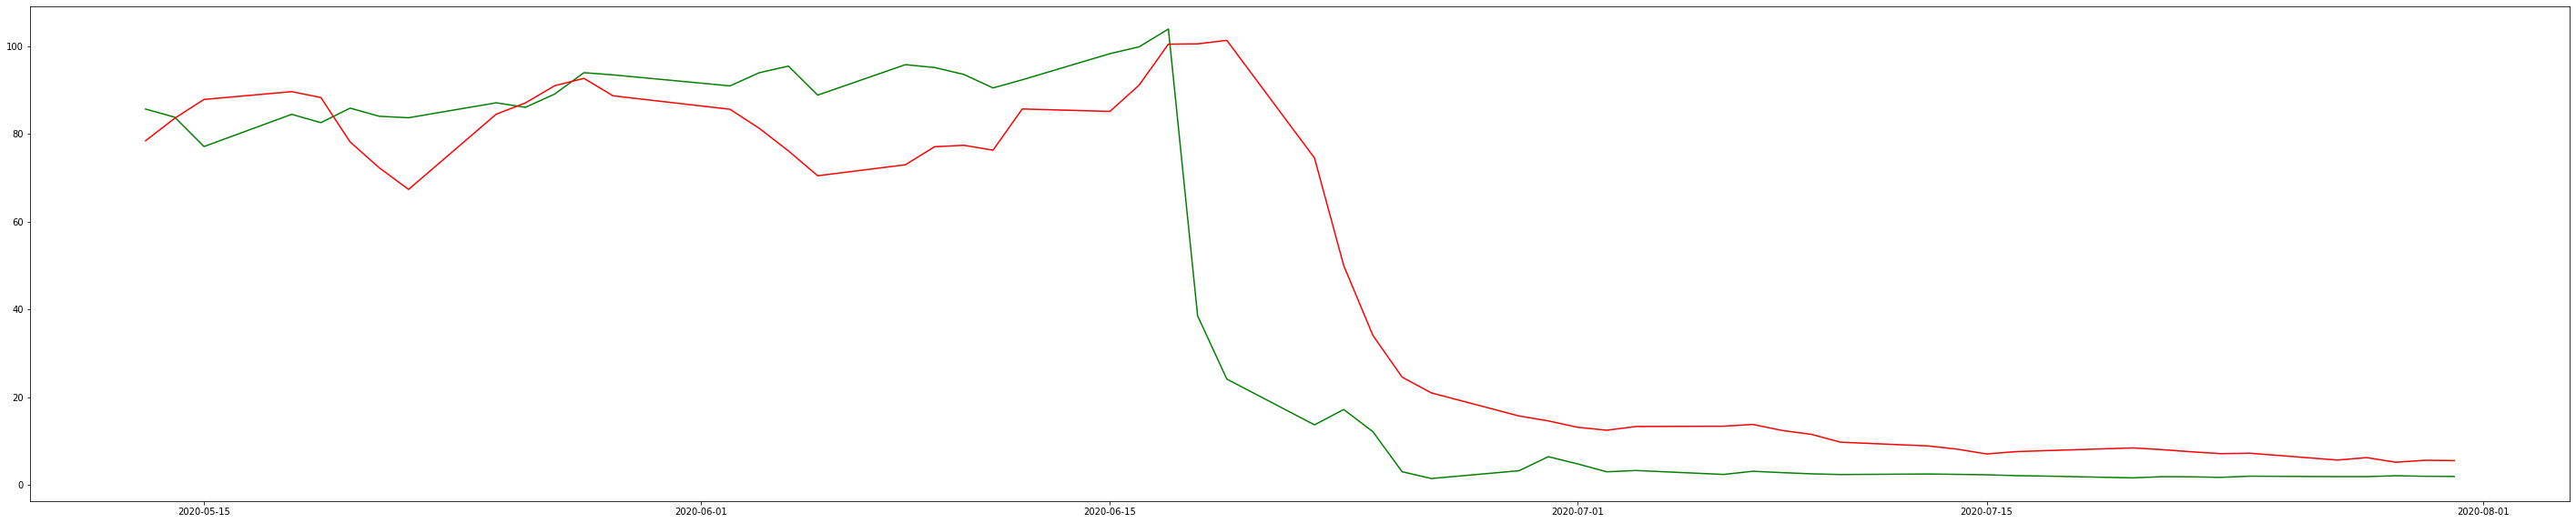

In [313]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(test["Date"], np.exp(test[output]), color="green")
plt.plot(test["Date"], np.exp(reg_predictions), color="red")

plt.show()

KeyError: 0

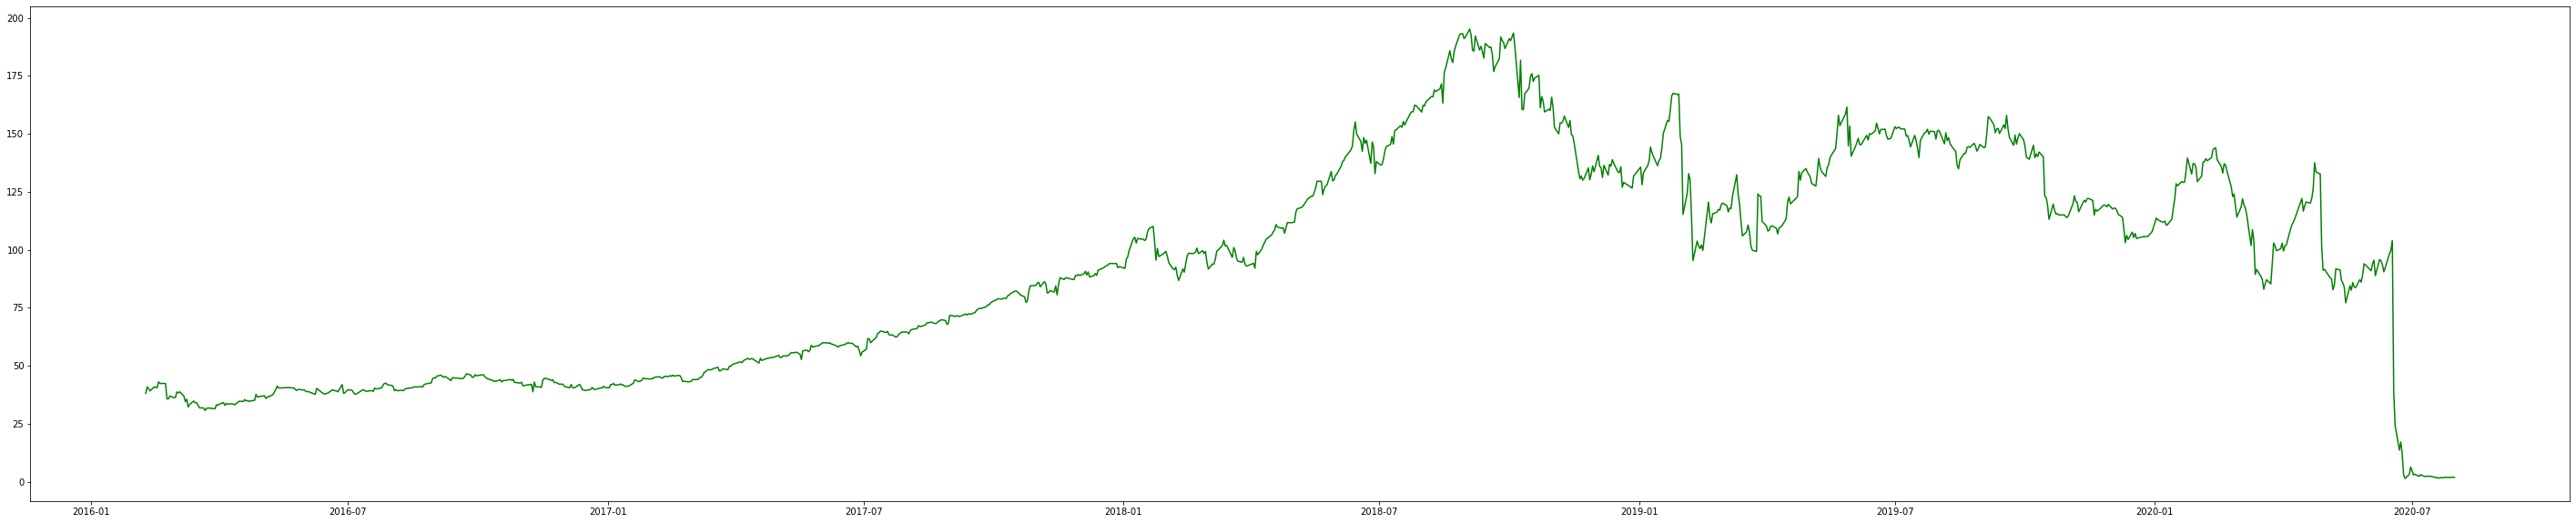

In [312]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(df_wdi_sentiment["Date"], np.exp(df_wdi_sentiment[output]), color="green")
plt.plot(df_wdi_sentiment["Date"], np.exp(reg_predictions[0]), color="red")

plt.show()

<h3>Regressionen mit verschiedenen zusätzlichen Feldern</h3>

In [222]:
df_wdi_sentiment = create_df(df)
df_wdi_sentiment.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
       'returns', 'returns_2', 'count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all', 'relation_pos_neg',
       'relation_neg_pos', 'relation_sum_pos_neg', 'relation_sum_neg_pos',
       'relation_prod_pos_neg', 'relation_prod_neg_pos'],
      dtype='object')

In [ ]:
#Do a more complex regression
#df_wdi_sentiment["sum_retweet_pos"]
#regressor = ["count_tweets_neg", "count_tweets_pos"]
#regressor = ["pct_pos_sum_all"]


regressor = ["sentiment_dummy"]



output = "returns_2"

lagnames = []

lag_num = 5
train_test = True

df_wdi_sentiment = create_df(df)
#df_wdi_sentiment = df_wdi_sentiment.drop(df_wdi_sentiment.index[1113:])
#df_wdi_sentiment = df_wdi_sentiment.drop(df_wdi_sentiment.index[1101:])
df_wdi_sentiment["sentiment_dummy"] = [1 if i > 0 else -1 if i < 0 else 0 for i in (df_wdi_sentiment.sum_pos_like_retweet-df_wdi_sentiment.sum_neg_like_retweet)]

#df_wdi_sentiment["Volume"] = np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])
#df_wdi_sentiment["Adj Close"] = np.log([1 if i == 0 else i for i in df_wdi_sentiment["Adj Close"]])

lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor)
#lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
lagnames.extend(lags)
lags, df_wdi_sentiment = lagit(df_wdi_sentiment, 1, ["Volume"], True)
lagnames.extend(lags)
#unwanted_lagnames = ["Lag_Adj Close_1", "Lag_Adj Close_2"]

#for each in unwanted_lagnames:
#    lagnames.remove(each)
    
#lagnames.append("Volume")

for each in range(len(lagnames)):
    print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))

reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)
#reg_predictions, reg_model = regression_all(df_wdi_sentiment, lagnames, output)

In [ ]:
print(reg_model.summary2())

In [ ]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(test["Date"], test[output], color="green")
plt.plot(test["Date"], reg_predictions, color="red")

plt.show()

In [ ]:
#Plot a Graph with multiple y axis
fig, ax1 = plt.subplots(figsize=(50,25))
ax2 = ax1.twinx()
    
ax1.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["returns_2"], color="green")
ax2.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["pct_pos_all"], color="red")

plt.show()

In [ ]:
# This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(100,50))


plt.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["Volume"], color="green")
plt.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["count_tweets_all"], color="red")

plt.show()

In [ ]:
#Calculate the scuared mean squared error on the predicted values based on the real values. 
np.sqrt(mean_squared_error(reg_test_y, reg_predictions))

In [ ]:
#Calulate the r2 values based on the prediccted and the real values, 
r2_score(reg_test_y, reg_predictions)

In [ ]:
#Print a plot over all values in the regression.
plt.figure(figsize=(50,10))


plt.scatter(df_wdi_sentiment["Date"], df_wdi_sentiment[output], color="green")
plt.plot(df_wdi_sentiment["Date"], all_predictions, color="red")

plt.show()

<h2>Outperform</h2>

In [ ]:
test["direction_LR"] = [1 if i > 0 else -1 for i in reg_predictions]

In [ ]:
test["strat_LR"] = test["direction_LR"] * test["returns"]

In [ ]:
np.exp(test[["returns", "strat_LR"]].sum())

In [ ]:
np.exp(test[["returns", "strat_LR"]].cumsum()).plot()

<h2>Plots for Visualisation</h2>

In [ ]:
def print_graphs(input_value, log = False):
    print("===============", input_value, ", ", log, "===============")
    fig, ax1 = plt.subplots(figsize=(50,25))
    ax2 = ax1.twinx()
    
    ax1.plot(df_wdi_sentiment["Date"], df_wdi_sentiment["returns_2"], color="green")
    if log:
        ax2.plot(df_wdi_sentiment["Date"], np.log(df_wdi_sentiment[input_value]), color="red")
    else:
        ax2.plot(df_wdi_sentiment["Date"], df_wdi_sentiment[input_value], color="red")

    plt.show()

input_values =  ['returns_2', 'count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all', 'relation_pos_neg',
       'relation_neg_pos', 'relation_sum_pos_neg', 'relation_sum_neg_pos',
       'relation_prod_pos_neg', 'relation_prod_neg_pos']

for each in input_values:
    print_graphs(each)
    print_graphs(each, True)

In [ ]:

plt.scatter(df_wdi_sentiment.Date, np.log(df_wdi_sentiment["Adj Close"]), color="blue")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent_all, color="red")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent, color="orange")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent_all, color="green")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent, color="yellow")


plt.show

In [ ]:
x = np.log(df_wdi_sentiment["bert_pos_percent_all"])
y = np.log(df_wdi_sentiment["Adj Close"])

plt.scatter(x, y)
plt.show()

<h2>Test</h2>

<h3>Testfunktionen und anderes nützliches </h3>

In [ ]:
def test(df):
    output = ["returns", "intraday_change", "Adj Close"]
    regressor = ["count_bert_pos", "count_bert_neg", "bert_pos_percent_all", "bert_neg_percent_all", 
       "bert_pos_percent", "bert_neg_percent"]
    
    for each_out in output:
        for each_in in regressor:
            df_wdi_sentiment = create_df(df)
            print("===================================",each_out,": ",each_in,"===============================================\n")
            lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, 5, each_in)
            reg_model, reg_predictions, test = regression(df_wdi_sentiment, lagnames, each_out)
            print("\n\n\n")
    return df_wdi_sentiment
df_wdi_sentiment = test(df)

<h3>Tests zum löschen</h3>

In [ ]:
df_wdi_sentiment["sentiment"] = df_wdi_sentiment["count_bert_pos"] - df_wdi_sentiment["count_bert_neg"]
df_wdi_sentiment["sentiment_dummy"] = [1 if i > 1 else -1 if i < 0 else 0 for i in df_wdi_sentiment["sentiment"]]

<h2>Alte Funktionen und alter Code</h2>

In [ ]:
#add data to df
def calculate_sentiment(df):
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df["tweet_id"].groupby(pd.to_datetime(df["created_at"]).apply(lambda x: x.date())).count()}).reset_index()
    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert]}).reset_index(drop=True)
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
#add data to df 
#In this DF the tweets are not only counted, also the retweet count is used.
def calculate_sentiment(df):    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert],
                                 "retweet_count": [1 if i == 0 else i+1 for i in df.retweet_count]}).reset_index(drop=True)
    
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df_sentiment["retweet_count"].groupby(pd.to_datetime(df_sentiment["created_at"]).apply(lambda x: x.date())).sum()}).reset_index()
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "retweet_count"]].reset_index(drop=True)
                        
    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "retweet_count"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
(df_wdi_sentiment["count_tweets_pos"] / df_wdi_sentiment["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
(df_wdi_sentiment["sum_pos_like_retweet"] / df_wdi_sentiment["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
(df_wdi_sentiment["prod_pos_like_retweet"] / df_wdi_sentiment["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
test_list = []
print(type(test_list))

In [ ]:
if type(test_list) == list:
    print(True)
else:
    print(False)

In [ ]:
df = pd.concat([df_en, df_de]).reset_index(drop=True)

In [ ]:
df_wdi_sentiment["Volume"] = np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
print(len(df_de))
print(len(df_en))
print(len(df_de) + len(df_en))
print(len(df))

In [ ]:
df_wdi_sentiment

In [ ]:
np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
np.log(211)

In [ ]:
np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
df_wdi_sentiment = create_df(df)

In [ ]:
df_wdi_sentiment[df_wdi_sentiment["relation_pos_neg"] < 0]

In [ ]:
[1 if i > 0 else -1 if i < 0 else 0 for i in (df_wdi_sentiment.count_tweets_pos-df_wdi_sentiment.count_tweets_neg)]

In [ ]:
df_wdi_sentiment.tail()

In [ ]:
df_wdi_sentiment.iloc[1139]

In [ ]:
df_wdi_sentiment

In [ ]:
len(create_df(df))

In [ ]:
df["Lag_"+each+"_"+str(i)] = df[each].shift(i)

In [95]:
df_wdi_sentiment = create_df(df)
df_wdi_sentiment["Adj_Close_prev_day"] = df_wdi_sentiment["Adj_Close"].shift(1)
df_wdi_sentiment.dropna(subset=["Adj_Close_prev_day"], inplace=True)

In [96]:
df_wdi_sentiment["Adj_Close_prev_day"]

1       45.893112
2       45.789028
3       44.455849
4       45.085274
5       42.091812
          ...    
1136     1.949200
1137     1.850000
1138     1.852600
1139     2.050000
1140     1.928000
Name: Adj_Close_prev_day, Length: 1140, dtype: float64

In [91]:
df_wdi_sentiment

,Date,Open,High,Low,Close,Adj_Close,Volume,returns,returns_2,count_tweets_all,...,pct_neg_prod,pct_pos_prod_all,pct_neg_prod_all,relation_pos_neg,relation_neg_pos,relation_sum_pos_neg,relation_sum_neg_pos,relation_prod_pos_neg,relation_prod_neg_pos,Adj_Close_prev_day
0,2016-02-01,47.090000,47.090000,46.299999,46.299999,45.893112,69,0.000000,0.000000,22.0,...,0.021739,0.146104,0.003247,3.000000,0.333333,10.500000,0.095238,45.000000,0.022222,None
1,2016-02-02,46.195000,46.195000,46.195000,46.195000,45.789028,0,-0.002270,0.997732,37.0,...,0.052632,0.037422,0.002079,3.000000,0.333333,4.000000,0.250000,18.000000,0.055556,None
2,2016-02-03,45.000000,45.000000,44.849998,44.849998,44.455849,90,-0.029548,0.970884,16.0,...,0.000000,0.463235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None
3,2016-02-04,45.485001,45.485001,45.485001,45.485001,45.085274,0,0.014059,1.014158,30.0,...,0.023256,0.103704,0.002469,7.000000,0.142857,6.333333,0.157895,42.000000,0.023810,None
4,2016-02-05,43.500000,44.000000,42.465000,42.465000,42.091812,110,-0.068702,0.933604,20.0,...,0.285714,0.022727,0.009091,2.500000,0.400000,3.000000,0.333333,2.500000,0.400000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2020-07-27,2.228000,2.516000,1.850000,1.850000,1.850000,25093,-0.052233,0.949107,736.0,...,0.983516,0.001364,0.081359,0.185792,5.382353,0.106227,9.413793,0.016760,59.665352,None
1137,2020-07-28,1.847000,1.869200,1.828000,1.852600,1.852600,2035,0.001404,1.001405,917.0,...,0.996102,0.000459,0.117247,0.108761,9.194444,0.049127,20.355556,0.003913,255.571502,None
1138,2020-07-29,1.850000,2.092500,1.830000,2.050000,2.050000,19941,0.101250,1.106553,1913.0,...,0.995327,0.000273,0.058186,0.152475,6.558442,0.046753,21.388889,0.004695,212.990165,None
1139,2020-07-30,2.055000,2.100000,1.928000,1.928000,1.928000,3200,-0.061357,0.940488,1267.0,...,0.984520,0.001224,0.077845,0.101796,9.823529,0.146528,6.824615,0.015723,63.599757,None


In [63]:
df_wdi_sentiment["Adj_Close"] + np.sign(df_wdi_sentiment["pct_pos_sum"]) * (df_wdi_sentiment["Adj_Close"] - df_wdi_sentiment["Adj_Close_prev_day"]).

0             NaN
1       35.723277
2       43.821476
3       39.296592
4       39.202427
          ...    
1131     1.750800
1132     1.855200
1133     2.247400
1134     1.806000
1135     1.890000
Length: 1136, dtype: float64

In [65]:
df_wdi_sentiment["Adj_Close"] + np.sign(df_wdi_sentiment["pct_pos_sum"]) * (df_wdi_sentiment["Adj_Close"] - df_wdi_sentiment["Adj_Close_prev_day"])

Series([], dtype: object)